Adpated from the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). 
---



# Let's get rolling with AdaBoost

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def fit_boosting(X, y, n_estimators=10):
    n_samples, n_features = X.shape
    D = np.ones((n_samples, ))
    estimators = []

    for t in range(n_estimators):
        D = D / np.sum(D)                   

        h = DecisionTreeClassifier(max_depth=1)  
        h.fit(X, y, sample_weight=D)        

        ypred = h.predict(X)   
        error = np.sum((y != ypred) * D)
        a = 0.5 * np.log((1 - error) / error)               

        m = (y == ypred) * 1 + (y != ypred) * -1    
        D *= np.exp(-a * m)
                 
        estimators.append((a, h))  

    return estimators

## AdaBoost and outliers

What happens to AdaBoost if we have a noisy dataset?


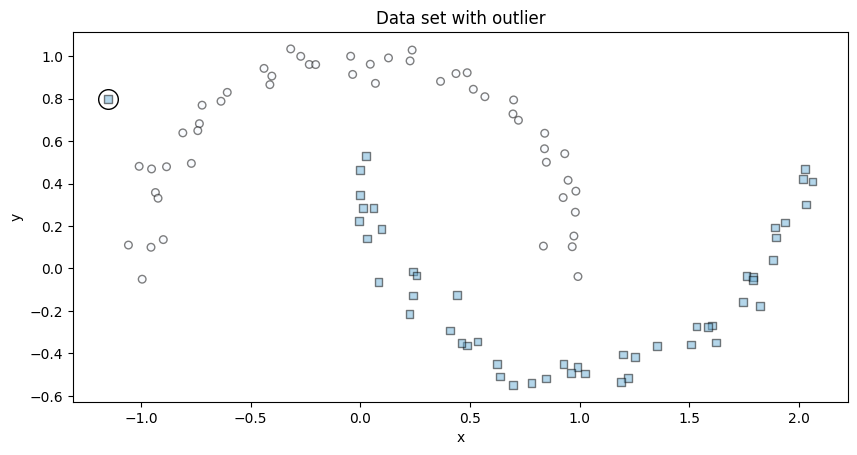

In [29]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from plot_utils import plot_2d_data, plot_2d_classifier, predict_boosting

# Generate some data
X, y = make_moons(n_samples=100, noise=0.05, random_state=13)

# Add an outlier
X = np.concatenate((X, [[-1.15, 0.8]]))
y = np.concatenate((y, [1]))
# Convert to -1/+1 labels from 0/1 labels
y = 2 * y - 1  

fig, ax1 = plt.subplots(1, 1)
fig.set_figwidth(10)


ax1.set_xlabel('x', fontsize=10);
ax1.set_ylabel('y', fontsize=10);
ax1.scatter([-1.15], [0.8], marker='o', s=200, c='w', edgecolors='k')
plot_2d_data(ax1, X, y, alpha=0.75, s=30,
             title='Data set with outlier', colormap='Blues')



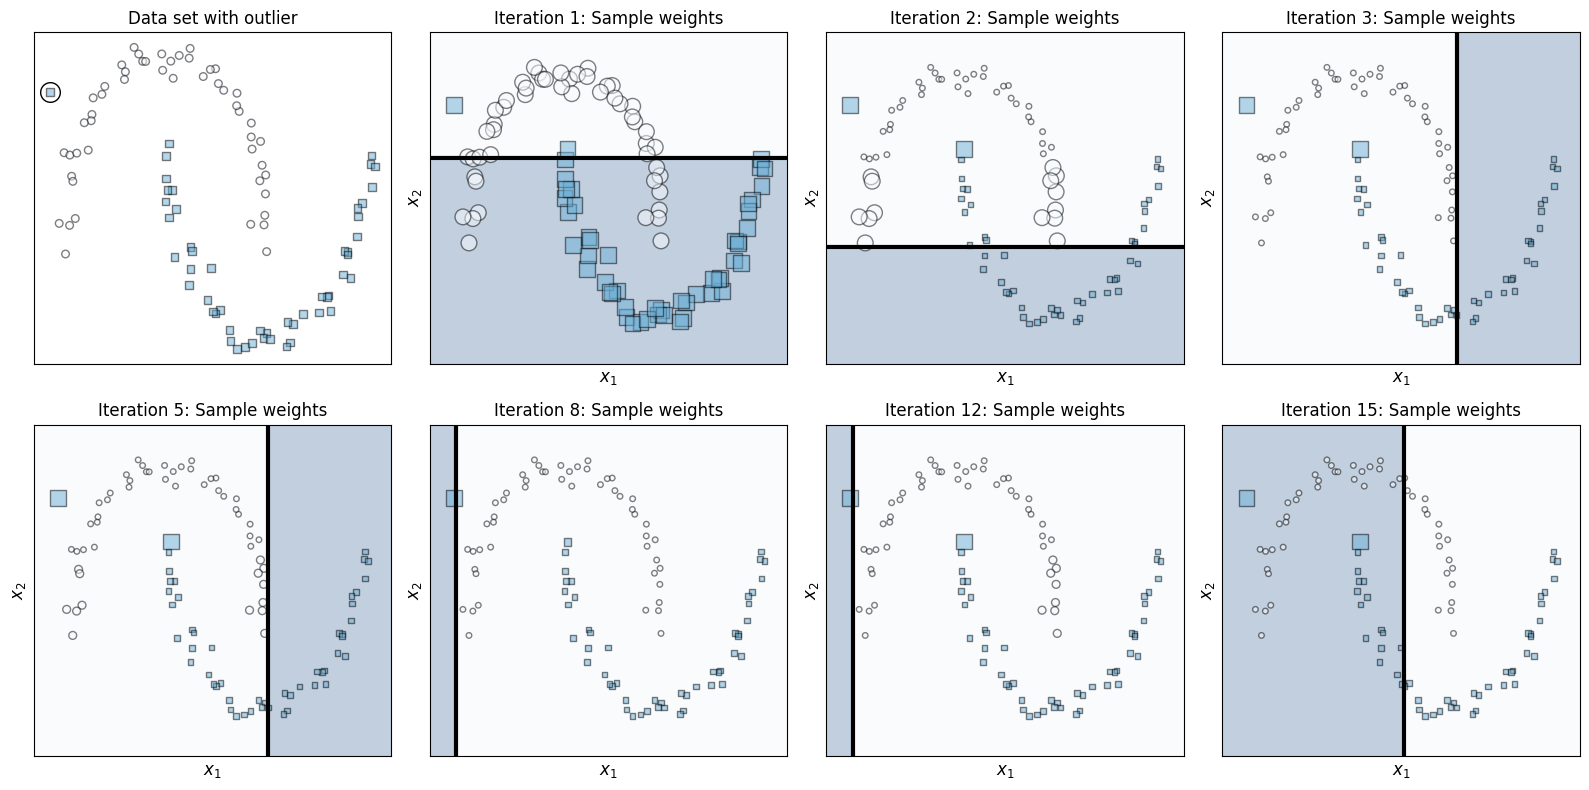

In [32]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

n_samples, n_features = X.shape
n_estimators = 55
D = np.ones((n_samples, ))                      # Initialize example weights
ensemble = []                                   # Initialize an empty ensemble

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Plot the data set 
ax[0, 0].scatter([-1.15], [0.8], marker='o', s=200, c='w', edgecolors='k')
plot_2d_data(ax[0, 0], X, y, alpha=0.75, s=30,
             title='Data set with outlier', colormap='Blues')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
axis_index = 0

for t in range(n_estimators):
    D = D / np.sum(D)                           # Normalize the sample weights

    # -- Plot the training examples in different sizes proportional to their weights
    s = D / np.max(D)
    s[(0.00 <= s) & (s < 0.25)] = 16
    s[(0.25 <= s) & (s < 0.50)] = 32
    s[(0.50 <= s) & (s < 0.75)] = 64
    s[(0.75 <= s) & (s <= 1.00)] = 128

    # if t in [0, 1, 2, 4, 7, 11, 14]:
    #     axis_index += 1
    #     r, c = np.divmod(axis_index, 4)
    #     title = 'Iteration {0}: Sample weights'.format(t + 1)
    #     plot_2d_data(ax[r, c], X, y, alpha=0.75, s=s, title=title, colormap='Blues')
    #     ax[r, c].set_xticks([])
    #     ax[r, c].set_yticks([])
        
    h = DecisionTreeClassifier(max_depth=1)  # Initialize a decision stump
    h.fit(X, y, sample_weight=D)                # Train a weak learner using sample weights
    ypred = h.predict(X)                        # Predict using the weak learner

    if t in [0, 1, 2, 4, 7, 11, 14]:
        axis_index += 1
        r, c = np.divmod(axis_index, 4)
        title = 'Iteration {0}: Sample weights'.format(t + 1)
        plot_2d_classifier(ax[r, c], X, y, predict_function=h.predict,
                   boundary_level=[0.0], alpha=0.25, xlabel='$x_1$', ylabel='$x_2$', s=s,
                   title=title, colormap='Blues')

        #plot_2d_data(ax[r, c], X, y, alpha=0.75, s=s, title=title, colormap='Blues')
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])


    e = 1 - accuracy_score(y, ypred, sample_weight=D)   # Weighted error of the weak learner
    a = 0.5 * np.log((1 - e) / e)               # Weak learner weight

    m = (y == ypred) * 1 + (y != ypred) * -1    # Identify correctly classified and misclassified points
    D *= np.exp(-a * m)                         # Update the sample weights

    ensemble.append((a, h))                     # Save the weighted weak hypothesis
    
fig.tight_layout()

Text(0.5, 1.0, 'Overall ensemble (err = 0.0%)')

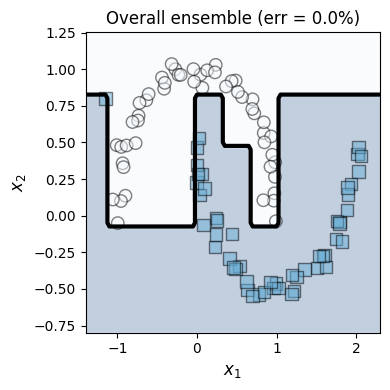

In [7]:
ypred = predict_boosting(X, ensemble)
err = (1 - accuracy_score(y, ypred)) * 100

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plot_2d_classifier(ax, X, y, predict_function=predict_boosting, predict_args=(ensemble), 
                   boundary_level=[0.0], alpha=0.25, xlabel='$x_1$', ylabel='$x_2$', s=80,
                   title=title, colormap='Blues')

fig.tight_layout()
ax.set_title('Overall ensemble (err = {0:3.1f}%)'.format(err), fontsize=12)

### Learning Rate

[learning rate](https://scikit-learn.org/stable/modules/ensemble.html#shrinkage-via-learning-rate) controls the contribution of each estimator to the ensemble.

For example, a learning rate of 0.75 tells AdaBoost to decrease the overall contribution of each base estimator by a factor of 0.75.  
When there are outliers, a high learning rate will cause their influence to grow proportionally quickly, which can absolutely kill the performance of your model. Therefore, one way to mitigate the effect of outliners is to lower the learning rate. 

In [19]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

We use [``StratifiedKFold``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) cross validation to ensure that the subsets preserve the percentage of samples for each class.

[Info about the dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Initialize
n_learning_rate_steps, n_folds = 10, 10
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)

splitter = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)

trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))

# Train AdaBoostClassifier for different learning rates and plot the results
stump = DecisionTreeClassifier(max_depth=1)
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(X, y)):
        model = AdaBoostClassifier(algorithm='SAMME', estimator=stump, n_estimators=10, learning_rate=rate)
        model.fit(X[trn, :], y[trn])

        trn_err[i, j] = (1 - accuracy_score(y[trn], model.predict(X[trn, :]))) * 100
        val_err[i, j] = (1 - accuracy_score(y[val], model.predict(X[val, :]))) * 100

        
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

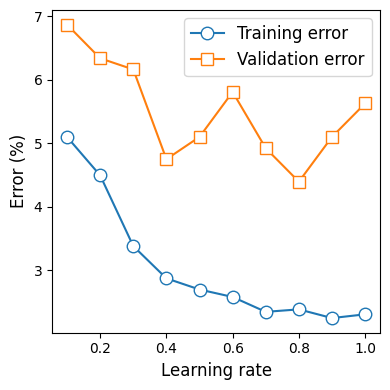

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(learning_rates, trn_err, linewidth=1.5, marker='o', markersize=9, mfc='w', label='Training error');
ax.plot(learning_rates, val_err, linewidth=1.5, marker='s', markersize=9, mfc='w', label='Validation error');
ax.legend(fontsize=12)
ax.set_xlabel('Learning rate', fontsize=12)
ax.set_ylabel('Error (%)', fontsize=12)

fig.tight_layout()

### Early Stopping and Pruning

Besides the learning_rate, the other important consideration for practical boosting is the number of base learners, n_estimators. It might be tempting to try to build an ensemble with a very large number of weak learners. However, this does not always translate to the best generalization performance.

In fact, it is often the case that we can achieve roughly the same performance with fewer base estimators than we think we might need. Identifying the least number of base estimators in order to build an effective ensemble is known as early stopping. 

In [13]:
n_estimator_steps, n_folds = 5, 10
number_of_stumps = np.arange(5, 50, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_stumps in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(X, y)):
        model = AdaBoostClassifier(algorithm='SAMME', estimator=stump,
                                   n_estimators=n_stumps, learning_rate=1.0)
        model.fit(X[trn, :], y[trn])

        trn_err[i, j] = 1 - accuracy_score(y[trn], 
                                           model.predict(X[trn, :]))
        val_err[i, j] = 1 - accuracy_score(y[val], 
                                           model.predict(X[val, :]))

trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

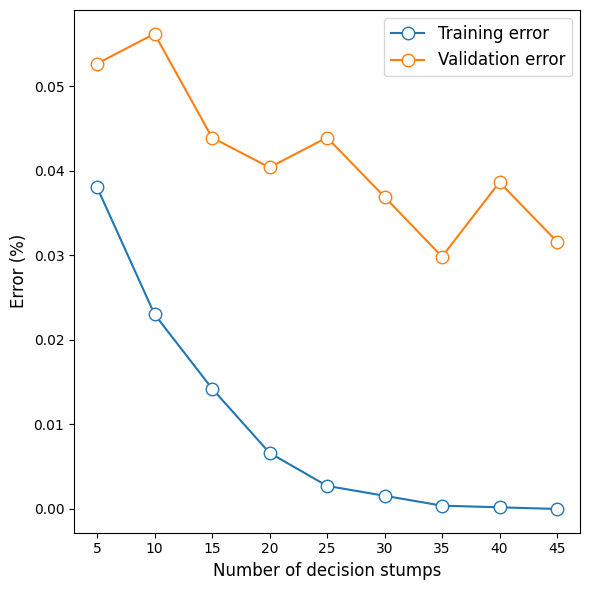

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.plot(number_of_stumps, trn_err, linewidth=1.5, marker='o', markersize=9, mfc='w', label='Training error');
ax.plot(number_of_stumps, val_err, linewidth=1.5, marker='o', markersize=9, mfc='w', label='Validation error');
ax.legend(fontsize=12)
ax.set_xlabel('Number of decision stumps', fontsize=12)
ax.set_ylabel('Error (%)', fontsize=12)

fig.tight_layout()